In [88]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import re
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from statistics import mode
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


In [89]:
df = pd.read_csv('train-2.csv')

In [90]:
df.head()

,Id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,TARGET
0,57094,1.0,3,0,2016-05-19 18:06:27,A FABULOUS 3BR IN MIDTOWN WEST! PERFECT APAR...,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,4bdc3d8c1aaa90d997ce2cb77680679b,['https://photos.renthop.com/2/7039994_07be01b...,4495,W 50 & AVE 10,medium
1,33389,1.0,1,9225efdfb57a50bf3ec17ebab082f94a,2016-06-16 02:01:49,Renovated Kitchen and Bathroom!,55 River Drive South,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,e5808a5e6cc13988fe596704428d38d5,['https://photos.renthop.com/2/7166774_03cf63a...,2570,55 River Drive South,medium
2,60458,1.0,0,320de7d3cc88e50a7fbbcfde1e825d21,2016-05-04 02:42:50,RARE AND BEST DEAL ON THE MARKET!!!! PERFECT S...,W 77 Street,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,d69d4e111612dd12ef864031c1148543,['https://photos.renthop.com/2/6962716_ec7f56f...,1795,22 W 77 Street,low
3,53048,1.0,2,ce6d18bf3238e668b2bf23f4110b7b67,2016-05-12 05:57:56,Newly renovated flex 2 apartment offers the ne...,John Street,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7002458_93f4010...,3400,100 John Street,low
4,592,1.0,3,fee4d465932160318364d9d48d272879,2016-06-16 06:06:15,LOW FEE apartments do not come around like thi...,West 16th Street,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,6fba9b3a8327c607b8b043716efee684,['https://photos.renthop.com/2/7170465_9c3f173...,5695,321 West 16th Street,low


In [91]:
df.photos = [len(eval(el)) for el in df.photos]
df.features = [eval(el) for el in df.features]
df.created = pd.DatetimeIndex(df.iloc[df.index].created).map(lambda x: x.dayofweek)
df.building_id = [0 if el == '0' else 1 for el in df.building_id]
df['photos_s'] = df.photos ** 2
df['price_f'] = df.price ** 7
df['ll'] = df.longitude * df.latitude
df['usik'] = df.bathrooms / (df.bedrooms + 1)

In [92]:
df.description.fillna('')
df['desc'] = [len([s for s in str(el) if s >= 'A' and s <= 'Z']) for el in df.description]
df['len_desc'] = [len(str(el)) for el in df.description]

In [93]:
df.drop(columns=['listing_id', 'description', 'display_address'], inplace = True)

In [94]:
df.drop(columns=['manager_id', 'street_address'], inplace = True)

In [95]:
df.head()

,Id,bathrooms,bedrooms,building_id,created,features,latitude,longitude,photos,price,TARGET,photos_s,price_f,ll,usik,desc,len_desc
0,57094,1.0,3,0,3,"[Laundry In Unit, No Fee, Elevator]",40.7647,-73.9918,3,4495,medium,9,7437624371966109167,-3016.253529,0.250000,177,476
1,33389,1.0,1,1,3,"[Dogs Allowed, Cats Allowed, No Fee]",40.7275,-74.0322,13,2570,medium,169,3947964295399478912,-3015.146426,0.500000,3,31
2,60458,1.0,0,1,2,"[Elevator, Hardwood Floors]",40.7798,-73.9751,6,1795,low,36,-2702167562018713205,-3016.689783,1.000000,130,280
3,53048,1.0,2,1,3,"[Swimming Pool, Doorman, Elevator, Fitness Cen...",40.7081,-74.0065,4,3400,low,16,-6425707320631623680,-3012.664003,0.333333,51,1158
4,592,1.0,3,1,3,"[Laundry in Building, Laundry in Unit, Dishwas...",40.7416,-74.0025,3,5695,low,9,815792154009947071,-3014.980254,0.250000,33,785


Поработаем с features

In [96]:
low_tags = list(df[df.TARGET == 'low'].features)
medium_tags = list(df[df.TARGET == 'medium'].features)
high_tags = list(df[df.TARGET == 'high'].features)

low_tags_set = ([item for sub in low_tags for item in sub])
medium_set = ([item for sub in medium_tags for item in sub])
high_tags_set = ([item for sub in high_tags for item in sub])

In [97]:
tags = Counter(low_tags_set + medium_set + high_tags_set)

In [98]:
tags = tags.most_common()[0:150]

In [99]:
tags = [tag[0] for tag in tags]

In [100]:
tags

['Elevator',
 'Hardwood Floors',
 'Cats Allowed',
 'Dogs Allowed',
 'Doorman',
 'Dishwasher',
 'No Fee',
 'Laundry in Building',
 'Fitness Center',
 'Pre-War',
 'Laundry in Unit',
 'Roof Deck',
 'Outdoor Space',
 'Dining Room',
 'High Speed Internet',
 'Balcony',
 'Swimming Pool',
 'Laundry In Building',
 'New Construction',
 'Terrace',
 'Exclusive',
 'Loft',
 'Garden/Patio',
 'Wheelchair Access',
 'Common Outdoor Space',
 'HARDWOOD',
 'SIMPLEX',
 'Fireplace',
 'prewar',
 'LOWRISE',
 'Garage',
 'Laundry Room',
 'Reduced Fee',
 'Laundry In Unit',
 'Furnished',
 'Multi-Level',
 'Prewar',
 'Private Outdoor Space',
 'PublicOutdoor',
 'Parking Space',
 'Roof-deck',
 'dishwasher',
 'elevator',
 'High Ceilings',
 'Renovated',
 'Pool',
 'LAUNDRY',
 'HIGH CEILINGS',
 'Green Building',
 'LIVE IN SUPER',
 'High Ceiling',
 'Washer in Unit',
 'Dryer in Unit',
 'Concierge',
 'Storage',
 'On-site laundry',
 'Stainless Steel Appliances',
 'Washer/Dryer',
 'Hardwood',
 'Newly renovated',
 'Light',
 'On

In [101]:
for tag in tags:
    df[tag] = np.full(len(df), 0)
    for ro in range(len(df)):
        if (tag in df.loc[ro, 'features']):
            df.loc[ro, tag] = 1

In [102]:
df.drop(columns = 'features', inplace = True)

In [103]:
df.head()

,Id,bathrooms,bedrooms,building_id,created,latitude,longitude,photos,price,TARGET,photos_s,price_f,ll,usik,desc,len_desc,Elevator,Hardwood Floors,Cats Allowed,Dogs Allowed,Doorman,Dishwasher,No Fee,Laundry in Building,Fitness Center,Pre-War,Laundry in Unit,Roof Deck,Outdoor Space,Dining Room,High Speed Internet,Balcony,Swimming Pool,Laundry In Building,New Construction,Terrace,Exclusive,Loft,Garden/Patio,Wheelchair Access,...,Live/Work,terrace,Gym,Shares OK,Health Club,Wheelchair Ramp,Laundry,Courtyard,Valet Parking,BROWNSTONE,FT Doorman,Full Service Garage,Washer/Dryer in building,Outdoor Entertainment Space,Live-In Superintendent,Washer & Dryer,Exposed Brick,On-site Parking Lot,Post-War,Sauna,Basement Storage,Microwave,on-site super,private-balcony,Private balcony,In-Unit Washer/Dryer,Private outdoor space,garden,gym,Hi Rise,MIDRISE,Sublet,Post War,DECORATIVE FIREPLACE,Pet Friendly,Common terrace,NO FEE,On-Site Parking,Guarantors Accepted,Concierge Service
0,57094,1.0,3,0,3,40.7647,-73.9918,3,4495,medium,9,7437624371966109167,-3016.253529,0.250000,177,476,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,33389,1.0,1,1,3,40.7275,-74.0322,13,2570,medium,169,3947964295399478912,-3015.146426,0.500000,3,31,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,60458,1.0,0,1,2,40.7798,-73.9751,6,1795,low,36,-2702167562018713205,-3016.689783,1.000000,130,280,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,53048,1.0,2,1,3,40.7081,-74.0065,4,3400,low,16,-6425707320631623680,-3012.664003,0.333333,51,1158,1,1,0,0,1,1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,592,1.0,3,1,3,40.7416,-74.0025,3,5695,low,9,815792154009947071,-3014.980254,0.250000,33,785,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Поработаем с местоположением

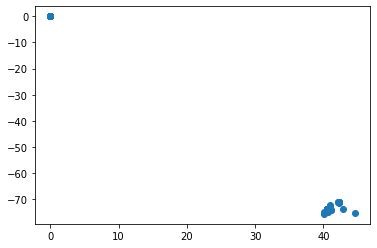

In [104]:
plt.scatter(df.latitude, df.longitude)

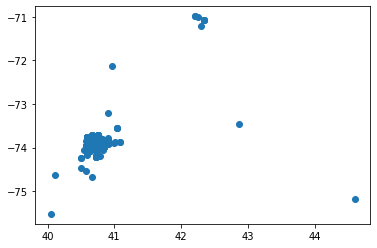

In [105]:
plt.scatter(df[df.latitude != 0].latitude, df[df.longitude != 0].longitude)

Интуитивно кажется, что число кластеров 3 подойдет

In [106]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['TARGET']), df.TARGET, test_size = 0.8)

In [107]:
km_mod = KMeans(n_clusters=3, random_state=42)

house_to_train = np.transpose([X_train.latitude, X_train.longitude])
house = np.transpose([df.latitude, df.longitude])
km_mod.fit(house_to_train)
labels = LabelEncoder().fit_transform(km_mod.predict(house))
df['loc_clusters'] = labels

In [108]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='TARGET'), df.TARGET, test_size = 0.8)

##Теперь поучим модельки

In [109]:
y_train

25339    medium
13116       low
17738       low
9518        low
15416    medium
          ...  
12384    medium
28       medium
16512       low
15955       low
13083    medium
Name: TARGET, Length: 6909, dtype: object

In [110]:
lr = LogisticRegression(class_weight= 'balanced', max_iter=1000)
knn = KNeighborsClassifier(n_neighbors=9)

lr.fit(X_train, y_train)
knn.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_pred_knn = knn.predict(X_test)
y_pred_const = np.full(y_test.shape, 'low')

In [111]:
pip install catboost

In [112]:

from catboost import CatBoostClassifier

In [113]:
cat_cl = CatBoostClassifier()
cat_cl.fit(X = X_train, y = y_train, silent = True, cat_features = list(tags))
y_pred_cat = cat_cl.predict(X_test)

In [114]:
print(accuracy_score(y_test, y_pred_const),accuracy_score(y_test, y_pred_knn), accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_cat) )

0.6951912291493288 0.6663892607736006 0.3776820928465463 0.7271411513550675


In [115]:
y_pred_cat[:, 0]

array(['low', 'low', 'low', ..., 'low', 'low', 'low'], dtype=object)

In [116]:
df_to_ans = pd.DataFrame()
dic = {'low' : 0, 'medium':1, 'high':2}
df_to_ans['c'] = [dic[el] for el in y_pred_const]
df_to_ans['lr'] = [dic[el] for el in y_pred_lr]
df_to_ans['knn'] = [dic[el] for el in y_pred_knn]
df_to_ans['ca'] = [dic[el] for el in y_pred_cat[:, 0]]

In [117]:
X_trainik, X_testik, y_trainik, y_testik = train_test_split(df_to_ans, y_test, train_size = 0.8)

In [118]:
log_regik = LogisticRegression(class_weight= 'balanced', max_iter=1000)
log_regik.fit(X_trainik, y_trainik)
y_predik = log_regik.predict(X_testik)
print(accuracy_score(y_testik, y_predik))

0.6799927641099855


In [119]:
def self_mode(List):

    return max(set(List), key = List.count)

In [120]:
y_pred_cat.shape

(27637, 1)

In [121]:
print(accuracy_score(y_test, [self_mode([y_pred_const[i], y_pred_knn[i], y_pred_lr[i], y_pred_cat[i][0]]) for i in range (len(X_test))] ))

0.6990628505264681


 Реальные данные

In [122]:
df = pd.read_csv('test-2.csv')


In [123]:
df.photos = [len(eval(el)) for el in df.photos]
df.features = [eval(el) for el in df.features]
df.created = pd.DatetimeIndex(df.iloc[df.index].created).map(lambda x: x.dayofweek)
df.building_id = [0 if el == '0' else 1 for el in df.building_id]
df['photos_s'] = df.photos ** 2
df['price_f'] = df.price ** 7
df['ll'] = df.longitude * df.latitude
df['usik'] = df.bathrooms / (df.bedrooms + 1)
df.description.fillna('')
df['desc'] = [len([s for s in str(el) if s >= 'A' and s <= 'Z']) for el in df.description]
df['len_desc'] = [len(str(el)) for el in df.description]

In [124]:
df.drop(columns=['listing_id', 'description', 'display_address'], inplace = True)

In [125]:
df.drop(columns=['manager_id', 'street_address'], inplace = True)

In [126]:
for tag in tags:
    df[tag] = np.full(len(df), 0)
    for ro in range(len(df)):
        if (tag in df.loc[ro, 'features']):
            df.loc[ro, tag] = 1

In [127]:
df.drop(columns = 'features', inplace = True)

In [128]:
house = np.transpose([df.latitude, df.longitude])
labels = LabelEncoder().fit_transform(km_mod.predict(house))
df['loc_clusters'] = labels

In [129]:
y_pred_lr = lr.predict(df)
y_pred_knn = knn.predict(df)
y_pred_const = np.full(len(df), 'low')
y_pred_cat = cat_cl.predict(df)

In [130]:
y_pred_const.shape

(14806,)

In [131]:
y_pred_knn.shape

(14806,)

In [132]:
df_to_ans = pd.DataFrame()
dic = {'low' : 0, 'medium':1, 'high':2}
df_to_ans['c'] = [dic[el] for el in y_pred_const]
df_to_ans['lr'] = [dic[el] for el in y_pred_lr]
df_to_ans['knn'] = [dic[el] for el in y_pred_knn]
df_to_ans['ca'] = [dic[el] for el in y_pred_cat[:, 0]]

to_ans = log_regik.predict(df_to_ans)

In [133]:
dfa = pd.DataFrame()
dfa['Id'] = pd.read_csv('test-2.csv').Id
dfa['TARGET'] = to_ans

In [134]:
dfa.to_csv('outik.csv', index = False)

In [135]:
dfa.shape

(14806, 2)